In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
(ds_train, ds_val), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.XHFLF0_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [ ]:
IMG_SIZE = (128, 128)

def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

train_ds = ds_train.map(preprocess).map(lambda x, y: (data_augmentation(x), y))
train_ds = train_ds.batch(32).prefetch(tf.data.AUTOTUNE)

val_ds = ds_val.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 345s 581ms/step - accuracy: 0.8971 - loss: 0.2382 - val_accuracy: 0.9671 - val_loss: 0.0817
Epoch 2/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 361s 546ms/step - accuracy: 0.9341 - loss: 0.1633 - val_accuracy: 0.9682 - val_loss: 0.0755
Epoch 3/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 343s 589ms/step - accuracy: 0.9402 - loss: 0.1442 - val_accuracy: 0.9712 - val_loss: 0.0715
Epoch 4/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 312s 535ms/step - accuracy: 0.9396 - loss: 0.1436 - val_accuracy: 0.9690 - val_loss: 0.0791
Epoch 5/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 309s 530ms/step - accuracy: 0.9438 - loss: 0.1370 - val_accuracy: 0.9714 - val_loss: 0.0692
Epoch 6/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 355s 587ms/step - accuracy: 0.9435 - loss: 0.1334 - val_accuracy: 0.9718 - val_loss: 0.0702
Epoch 7/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 342s 587ms/step - accuracy: 0.9461 - loss: 0.1321 - val_accuracy: 0.9740 - val_loss: 0.0679
Epoch 8/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 382s 585ms/step - accuracy: 0.9416 -

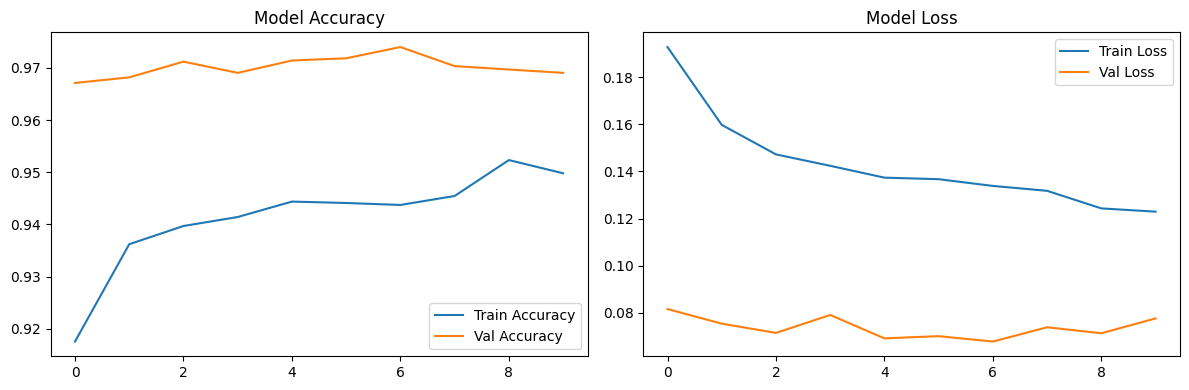

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
model.save("cat_dog_mobilenetv2.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


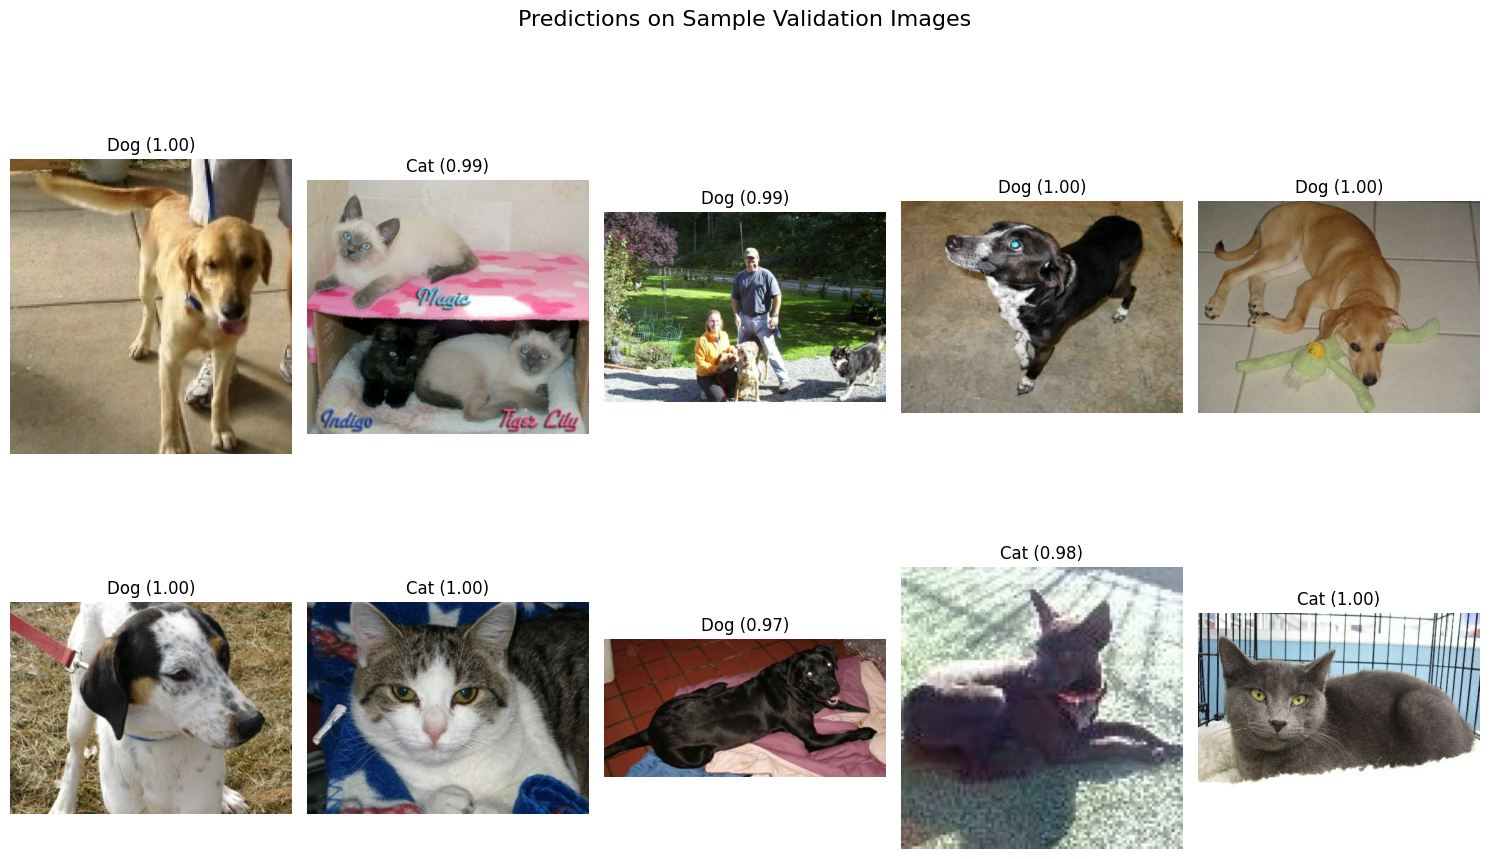

In [ ]:
plt.figure(figsize=(15, 10))
for i, (image, label) in enumerate(ds_val.take(10)):
    img = tf.image.resize(image, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.expand_dims(img, axis=0)
    prediction = model.predict(img)[0][0]
    pred_label = 'Dog' if prediction > 0.5 else 'Cat'
    confidence = prediction if prediction > 0.5 else 1 - prediction

    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.title(f"{pred_label} ({confidence:.2f})")
    plt.axis('off')

plt.suptitle("Predictions on Sample Validation Images", fontsize=16)
plt.tight_layout()
plt.show()